## Reddit data-set for sarcasm detection (pt 2)

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
nltk.download('vader_lexicon') # VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment intensity tool added to NLTK in 2014
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# Importing the Keras libraries and packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as lg
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [3]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

In [4]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
from textblob import TextBlob

## Analysis on the comments

In order to prove that one of the causes of the low performances of the algorithms might be the fact that we are indirectly computing the probability of receiving a sarcastic comment considering the parent comments and not the comments themselves, to which the label actually refer, we will conduct the same analysis as in part 1 focusing on the comments.

In [5]:
reddit = pd.read_csv('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/Dataset/train-balanced-sarcasm.csv')
reddit.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [6]:
reddit.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [7]:
reddit = reddit[reddit['comment'].notna()]
reddit.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [8]:
red_sample = reddit.sample(frac = 0.05) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1]) 

50539
10


In [9]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [10]:
# We drop all the columns but the label, the comment and the subreddit ones:
red_sample.drop(['author', 'score', 'date', 'created_utc'], axis=1, inplace=True)
red_sample.head(10)

,label,comment,subreddit,ups,downs,parent_comment
608193,0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...
46703,0,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.
182416,0,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...
18022,0,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...
940838,0,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...
3181,0,i was expecting you to leave your house to see...,pcmasterrace,-1,-1,Taking the RGB up a notch.
758912,1,Uhh that quarter final vs h2k was really close...,leagueoflegends,7,0,...What do you mean a serious contender?
671952,0,"I mean the ""target"" wording - Hearthstone does...",hearthstone,0,0,"Ah, good point, should just be one target mini..."
973729,0,Just another example of how we don't actually ...,Anarcho_Capitalism,7,0,Taxpayer Bailout of Underwater Homes Begins: E...
578557,0,"On the very edge of my bed, slowly falling off.",AskReddit,1,0,"You are suddenly shifted 2 feet to the left, w..."


In [11]:
red_sample = red_sample.reset_index(drop=True)
red_sample

,label,comment,subreddit,ups,downs,parent_comment
0,0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...
1,0,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.
2,0,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...
3,0,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...
4,0,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...
...,...,...,...,...,...,...
50534,1,He's won 2 UEFA Super Cups to Keane's 0 though,reddevils,3,0,Gerrard has no grounds to even claim to be on ...
50535,1,"Well yeah, she's your wife!",AskReddit,3,0,My wife asked me out. I though it was awesome!
50536,1,Clearly playing the really really long con!,bestoflegaladvice,12,0,"Yep, real life. Their submissions contain pics..."
50537,1,very creative,pcmasterrace,2,0,When Console Peasants Can't Handle the Poor Ch...


In [12]:
# Find the number of characters for each string in the red_sample dataset
red_sample['char'] = red_sample['comment'].str.len()
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char
0,0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...,89
1,0,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.,72
2,0,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...,86
3,0,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...,14
4,0,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...,22


In [13]:
# Number of punctuation symbols
red_sample['punct'] = red_sample['comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct
0,0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...,89,1
1,0,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.,72,3
2,0,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...,86,4
3,0,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...,14,1
4,0,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...,22,1


In [14]:
# Find the number of tokens for each string in the red_sample dataset
red_sample['tokens'] = red_sample['comment'].str.split().str.len()
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens
0,0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...,89,1,18
1,0,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.,72,3,12
2,0,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...,86,4,18
3,0,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...,14,1,1
4,0,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...,22,1,5


In [15]:
# Cleaning the text of the comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [16]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_sample["clean"] = red_sample["comment"].apply(cleanText)
red_sample["clean_parent"] = red_sample["parent_comment"].apply(cleanText)
red_sample.head()
endTime = timer()

In [17]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the comments is: 12.0 minutes and 2.2 seconds


In [18]:
red_copy = red_sample.copy()

In [19]:
boh = red_copy[['clean','clean_parent']]

In [20]:
boh["keywords_parent"] = boh["clean_parent"].str.split("[^\w+]").map(set)
boh["keywords_children"] = boh["clean"].str.split("[^\w+]").map(set)

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
boh['common_words'] = [set(x[0].split()) & set(x[1].split()) for x in boh.values]
boh['overlap_count'] = boh['common_words'].str.len()
boh

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,clean,clean_parent,keywords_parent,keywords_children,common_words,overlap_count
0,place minut queue ban player fail vote could s...,na pro dodg fpl match readi like team multipl ...,"{faceit, match, ban, pro, abl, problem, addres...","{fail, ban, queue, minut, vote, could, solut, ...","{ban, queue}",2
1,venezuela price made currenc matter,sound like someth drew carey would say,"{say, would, carey, sound, like, drew, someth}","{matter, venezuela, price, made, currenc}",{},0
2,way deng play know team would bite trade,would say team get playoff lot luck even proba...,"{someon, playoff, luck, focus, may, even, get,...","{know, deng, would, trade, play, way, team, bite}","{deng, would, team, trade}",4
3,inconceiv,yes use quot mani time year say unposs sound w...,"{incorrect, say, weird, quot, time, yes, sound...",{inconceiv},{},0
4,saw video,woman russian sure appar gibberish,"{appar, sure, russian, gibberish, woman}","{video, saw}",{},0
...,...,...,...,...,...,...
50534,uefa super cup kean though,gerrard ground even claim list,"{even, claim, ground, list, gerrard}","{cup, super, though, uefa, kean}",{},0
50535,well yeah wife,wife ask though awesom,"{though, wife, ask, awesom}","{well, yeah, wife}",{wife},1
50536,clear play realli realli long con,yep real life submiss contain pic babi cute li...,"{littl, yep, submiss, find, hope, cute, contai...","{con, realli, clear, play, long}",{},0
50537,creativ,consol peasant ca handl poor choic made,"{choic, handl, peasant, ca, poor, made, consol}",{creativ},{},0


### Sentiment analysis

In [22]:
all_comments = red_copy['comment']
all_sent_values = []
all_sentiments = []

In [23]:
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [24]:
sample = red_copy['comment'][1231]
print(sample)
print('Sentiment: ')
print(sentiment_value(sample))

so fucking judgmental
Sentiment: 
0.0


In [25]:
for i in range(0, red_copy.shape[0]):
    all_sent_values.append(sentiment_value(red_copy['comment'][i]))

In [26]:
all_comments = pd.DataFrame(all_comments)
all_comments

,comment
0,Placing a 5 minute queue ban on the player tha...
1,"Venezuela where the prices are made up, and th..."
2,"With the way Deng's playing, I don't know any ..."
3,inconceivable!
4,you saw the video too?
...,...
50534,He's won 2 UEFA Super Cups to Keane's 0 though
50535,"Well yeah, she's your wife!"
50536,Clearly playing the really really long con!
50537,very creative


In [27]:
#Sentiment Analysis on the dataset
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0, red_copy.shape[0]):
    sent = all_sent_values[i]
    if (sent<=1 and sent>0):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(3)
    elif (sent==0):
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(2)
    else:
        SENTIMENT.append('Highly Negative')
        SENTIMENT_VALUE.append(1)

In [28]:
all_comments['sentiment_value'] = SENTIMENT_VALUE
all_comments['sentiment'] = SENTIMENT

In [29]:
red_final1 = pd.merge(red_copy, all_comments, left_index=True, right_index=True)

In [30]:
red_final = pd.merge(red_final1, boh, left_index=True, right_index=True)

In [31]:
red_final.drop(['comment_y','clean_y','clean_parent_y'], axis=1, inplace=True)

In [32]:
red_final.rename(columns={'comment_x':'comment','clean_x':'clean','clean_parent_x':'clean_parent'}, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_parent,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count
0,0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...,89,1,18,place minut queue ban player fail vote could s...,na pro dodg fpl match readi like team multipl ...,1,Highly Negative,"{faceit, match, ban, pro, abl, problem, addres...","{fail, ban, queue, minut, vote, could, solut, ...","{ban, queue}",2
1,0,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.,72,3,12,venezuela price made currenc matter,sound like someth drew carey would say,2,Neutral,"{say, would, carey, sound, like, drew, someth}","{matter, venezuela, price, made, currenc}",{},0
2,0,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...,86,4,18,way deng play know team would bite trade,would say team get playoff lot luck even proba...,3,Positive,"{someon, playoff, luck, focus, may, even, get,...","{know, deng, would, trade, play, way, team, bite}","{deng, would, team, trade}",4
3,0,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...,14,1,1,inconceiv,yes use quot mani time year say unposs sound w...,2,Neutral,"{incorrect, say, weird, quot, time, yes, sound...",{inconceiv},{},0
4,0,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...,22,1,5,saw video,woman russian sure appar gibberish,2,Neutral,"{appar, sure, russian, gibberish, woman}","{video, saw}",{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50534,1,He's won 2 UEFA Super Cups to Keane's 0 though,reddevils,3,0,Gerrard has no grounds to even claim to be on ...,46,2,10,uefa super cup kean though,gerrard ground even claim list,3,Positive,"{even, claim, ground, list, gerrard}","{cup, super, though, uefa, kean}",{},0
50535,1,"Well yeah, she's your wife!",AskReddit,3,0,My wife asked me out. I though it was awesome!,27,3,5,well yeah wife,wife ask though awesom,3,Positive,"{though, wife, ask, awesom}","{well, yeah, wife}",{wife},1
50536,1,Clearly playing the really really long con!,bestoflegaladvice,12,0,"Yep, real life. Their submissions contain pics...",43,1,7,clear play realli realli long con,yep real life submiss contain pic babi cute li...,3,Positive,"{littl, yep, submiss, find, hope, cute, contai...","{con, realli, clear, play, long}",{},0
50537,1,very creative,pcmasterrace,2,0,When Console Peasants Can't Handle the Poor Ch...,13,0,2,creativ,consol peasant ca handl poor choic made,3,Positive,"{choic, handl, peasant, ca, poor, made, consol}",{creativ},{},0


In [33]:
capital = []

In [34]:
for i in range(0, red_copy.shape[0]):
    capital.append(sum(map(str.isupper, red_copy['comment'][i].split())))

In [35]:
red_final['cap'] = capital

In [36]:
red_final['uppercase'] = red_final['parent_comment'].str.findall(r'[A-Z]').str.len()

### Polarity analysis with TextBlob

In [37]:
red_final[['polarity', 'subjectivity']] = red_final['comment'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,...,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...,89,1,18,place minut queue ban player fail vote could s...,...,1,Highly Negative,"{faceit, match, ban, pro, abl, problem, addres...","{fail, ban, queue, minut, vote, could, solut, ...","{ban, queue}",2,0,20,-0.250000,0.328571
1,0,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.,72,3,12,venezuela price made currenc matter,...,2,Neutral,"{say, would, carey, sound, like, drew, someth}","{matter, venezuela, price, made, currenc}",{},0,0,3,0.000000,0.000000
2,0,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...,86,4,18,way deng play know team would bite trade,...,3,Positive,"{someon, playoff, luck, focus, may, even, get,...","{know, deng, would, trade, play, way, team, bite}","{deng, would, team, trade}",4,1,4,0.000000,0.000000
3,0,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...,14,1,1,inconceiv,...,2,Neutral,"{incorrect, say, weird, quot, time, yes, sound...",{inconceiv},{},0,0,2,0.000000,0.000000
4,0,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...,22,1,5,saw video,...,2,Neutral,"{appar, sure, russian, gibberish, woman}","{video, saw}",{},0,0,4,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50534,1,He's won 2 UEFA Super Cups to Keane's 0 though,reddevils,3,0,Gerrard has no grounds to even claim to be on ...,46,2,10,uefa super cup kean though,...,3,Positive,"{even, claim, ground, list, gerrard}","{cup, super, though, uefa, kean}",{},0,1,1,0.333333,0.666667
50535,1,"Well yeah, she's your wife!",AskReddit,3,0,My wife asked me out. I though it was awesome!,27,3,5,well yeah wife,...,3,Positive,"{though, wife, ask, awesom}","{well, yeah, wife}",{wife},1,0,2,0.000000,0.000000
50536,1,Clearly playing the really really long con!,bestoflegaladvice,12,0,"Yep, real life. Their submissions contain pics...",43,1,7,clear play realli realli long con,...,3,Positive,"{littl, yep, submiss, find, hope, cute, contai...","{con, realli, clear, play, long}",{},0,0,4,0.018750,0.391667
50537,1,very creative,pcmasterrace,2,0,When Console Peasants Can't Handle the Poor Ch...,13,0,2,creativ,...,3,Positive,"{choic, handl, peasant, ca, poor, made, consol}",{creativ},{},0,0,9,0.650000,1.000000


In [38]:
red_final.drop(['sentiment_value'], axis=1, inplace=True)

## Wordcloud
We try wordcloud with the first comment of the dataset.

Placing a 5 minute queue ban on the player that fails to vote could be a simple solution.


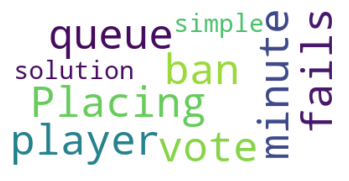

In [39]:
# Start with the first parent comment:
from wordcloud import WordCloud
example = red_sample.comment[0]
print(example)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(example)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Wordcloud on all the comments.

In [40]:
# Wordcloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_sample['comment'][red_sample["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Wordcloud for Non sarcastic comments:

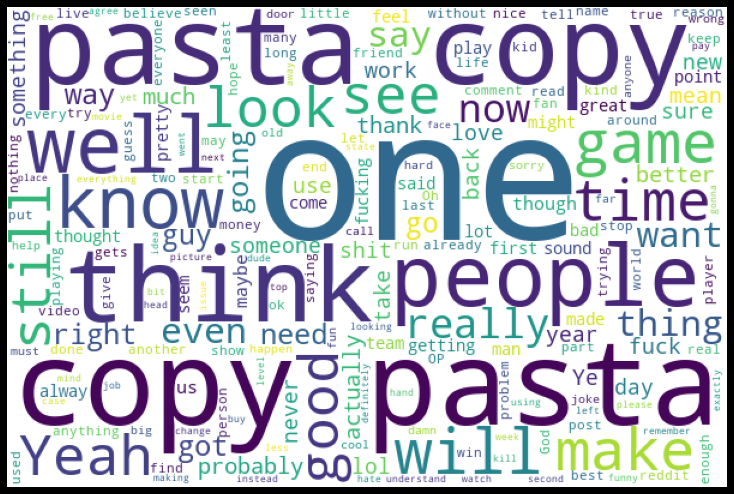

In [41]:
myWordCloud(0)

Wordcloud for Sarcastic comments:

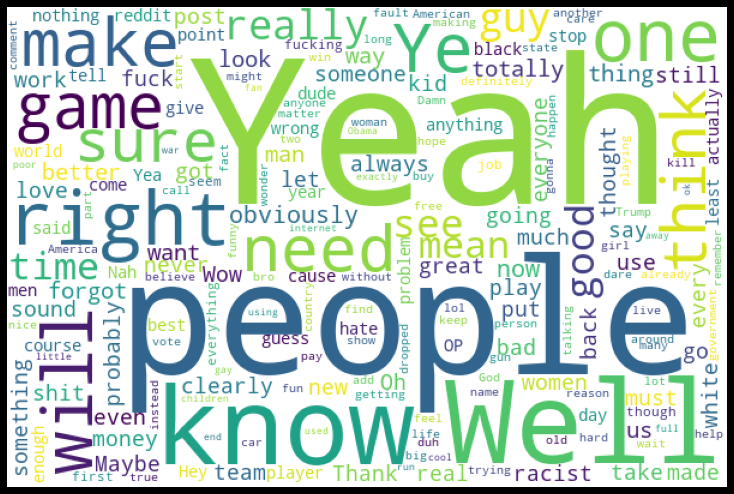

In [42]:
myWordCloud(1)

#### Wordcloud with the cleaned version of the comments:

In [43]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_sample['clean'][red_sample["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Wordcloud for Non sarcastic comments:

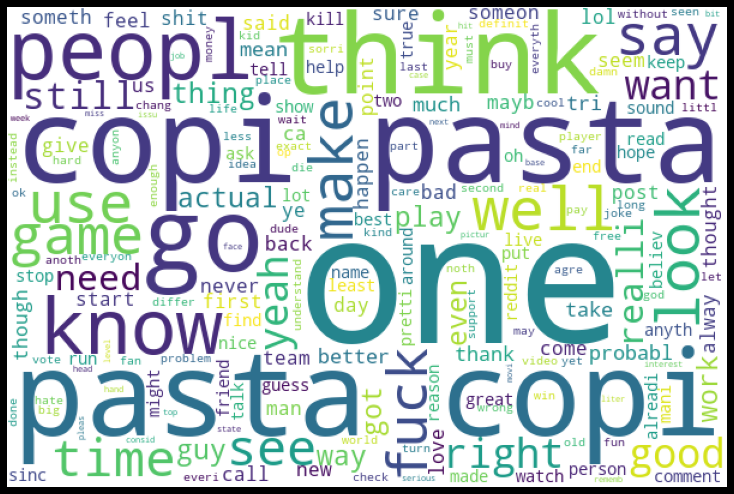

In [44]:
myWordCloudCleaned(0)

Wordcloud for Sarcastic comments:

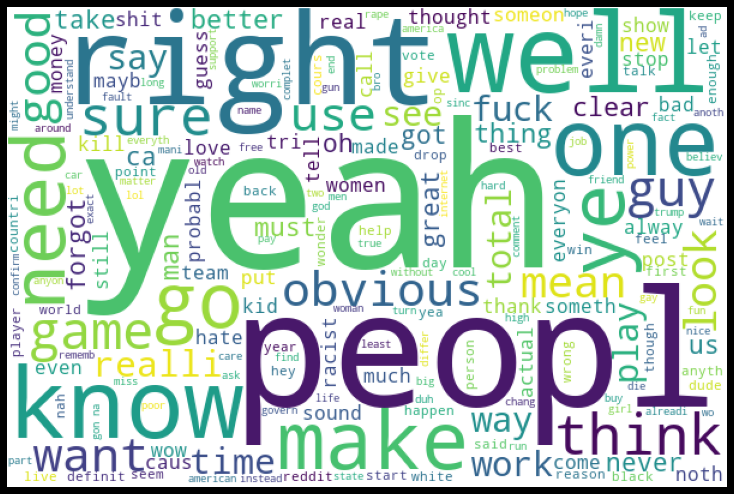

In [45]:
myWordCloudCleaned(1)

## Split into train and test sets

In [46]:
## Let's check the number of unique values in the subreddit columns
red_sample['subreddit'].nunique()

4038

In [47]:
X = red_final.drop(['label'], axis = 1) 
y = red_final["label"]

In [48]:
#X = red_sample[['clean','subreddit']]
#y = red_sample['label']

In [49]:
X_train, red_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [50]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

In [51]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(32344, 19)
(8087, 19)
(10108, 19)
(32344,)
(8087,)
(10108,)


## Classification algorithms

### First alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### TF-IDF on cleaned comments
TF-IDF focusing on the comments from which we have removed the punctuation and on which we have performed stemmization.

In [52]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
comment_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=3)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [54]:
clean_train = comment_vectorizer.fit_transform(red_train['clean'])
clean_valid = comment_vectorizer.transform(red_val['clean'])
clean_test = comment_vectorizer.transform(red_test['clean'])

In [55]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [56]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#### Naive Bayes

In [58]:
naive_bayes1 = NB.fit(reddit_train, y_train)

In [59]:
naiveBayes_predict1 = naive_bayes1.predict(reddit_test)

In [60]:
metrics.accuracy_score(y_test, naiveBayes_predict1)

0.6392956074396517

With Cross Validation

In [61]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [62]:
NB_cv1 = cross_val_score(NB, reddit_train, y_train, n_jobs = -1)
NB_cv1

array([0.64260318, 0.62915443, 0.63889318, 0.63085485, 0.62167594])

#### Logistic Regression

In [63]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [64]:
## Fit the model
logit_model1 = logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished


In [65]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test, logit_model1.predict_proba(reddit_test)[:,1])

0.7085211032918

With Cross validation:

In [66]:
logit_cv1 = cross_val_score(logit, reddit_train, y_train, n_jobs = -1)
logit_cv1

array([0.65775236, 0.64955944, 0.65048694, 0.64693152, 0.64022882])

#### Random forest

In [67]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
rf_model1 = random_forest.fit(reddit_train, y_train)

In [68]:
randomForest_predict1 = rf_model1.predict(reddit_test)

In [69]:
metrics.accuracy_score(y_test, randomForest_predict1)

0.5477839335180056

With Cross validation:

In [70]:
rf_cv1 = cross_val_score(random_forest, reddit_train, y_train, n_jobs = -1)
rf_cv1

array([0.58154274, 0.57396816, 0.56113773, 0.57396816, 0.56632653])

### Most important features

In [71]:
clean_train

<32344x9822 sparse matrix of type '<class 'numpy.float64'>'
	with 173138 stored elements in Compressed Sparse Row format>

In [73]:
features = np.array(comment_vectorizer.get_feature_names())

In [74]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=40) 
train = selector.fit_transform(clean_train, y_train)
print(train.shape)

(32344, 40)


In [75]:
most_important_feats1 = pd.DataFrame(features[selector.get_support()])
most_important_feats1

,0
0,add
1,amirit
2,black
3,clear
4,dare
5,drop
6,duh
7,everyon
8,everyon know
9,fault


## Second Alternative

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [76]:
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_parent
0,0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...,89,1,18,place minut queue ban player fail vote could s...,na pro dodg fpl match readi like team multipl ...
1,0,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.,72,3,12,venezuela price made currenc matter,sound like someth drew carey would say
2,0,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...,86,4,18,way deng play know team would bite trade,would say team get playoff lot luck even proba...
3,0,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...,14,1,1,inconceiv,yes use quot mani time year say unposs sound w...
4,0,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...,22,1,5,saw video,woman russian sure appar gibberish


In [77]:
red_sample['text'] = red_sample.clean + " " + red_sample.subreddit
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_parent,text
0,0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...,89,1,18,place minut queue ban player fail vote could s...,na pro dodg fpl match readi like team multipl ...,place minut queue ban player fail vote could s...
1,0,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.,72,3,12,venezuela price made currenc matter,sound like someth drew carey would say,venezuela price made currenc matter nottheonion
2,0,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...,86,4,18,way deng play know team would bite trade,would say team get playoff lot luck even proba...,way deng play know team would bite trade lakers
3,0,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...,14,1,1,inconceiv,yes use quot mani time year say unposs sound w...,inconceiv nfl
4,0,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...,22,1,5,saw video,woman russian sure appar gibberish,saw video videos


In [78]:
# We drop all the columns of the comments and that containing the cleaned text:
red_sample.drop(['comment', 'clean'], axis=1, inplace=True)
red_sample.head(10)

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean_parent,text
0,0,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...,89,1,18,na pro dodg fpl match readi like team multipl ...,place minut queue ban player fail vote could s...
1,0,nottheonion,-1,-1,Sounds like something Drew Carey would say.,72,3,12,sound like someth drew carey would say,venezuela price made currenc matter nottheonion
2,0,lakers,-1,-1,I would say no; this team gets to the playoffs...,86,4,18,would say team get playoff lot luck even proba...,way deng play know team would bite trade lakers
3,0,nfl,-1,-1,Yes! I've used that quote so many times over t...,14,1,1,yes use quot mani time year say unposs sound w...,inconceiv nfl
4,0,videos,264,0,The woman is Russian. ~~Not sure about the guy...,22,1,5,woman russian sure appar gibberish,saw video videos
5,0,pcmasterrace,-1,-1,Taking the RGB up a notch.,83,0,17,take rgb notch,expect leav hous see whole hous lit like pcmas...
6,1,leagueoflegends,7,0,...What do you mean a serious contender?,53,1,10,mean serious contend,uhh quarter final vs realli close right league...
7,0,hearthstone,0,0,"Ah, good point, should just be one target mini...",75,8,12,ah good point one target minion oh also abl ta...,mean target word hearthston use target magic h...
8,0,Anarcho_Capitalism,7,0,Taxpayer Bailout of Underwater Homes Begins: E...,63,2,11,taxpay bailout underwat home begin emin domain,anoth exampl actual properti Anarcho_Capitalism
9,0,AskReddit,1,0,"You are suddenly shifted 2 feet to the left, w...",47,2,10,sudden shift feet left differ,edg bed slowli fall AskReddit


#### Wordclouds with the new text:

In [79]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_sample['text'][red_sample["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

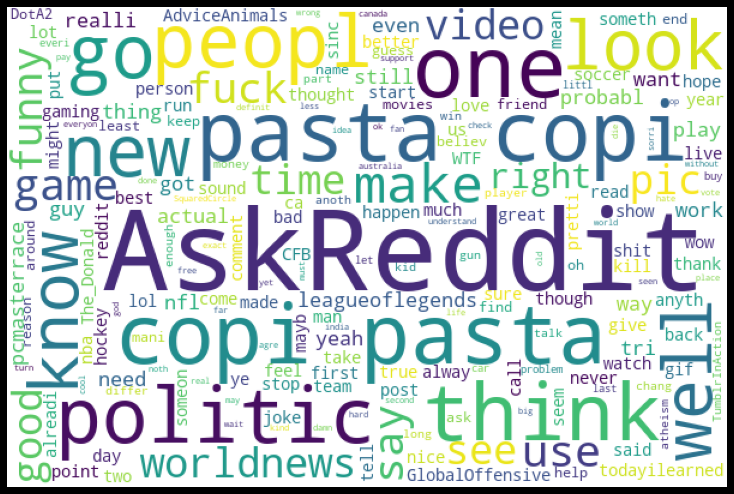

In [80]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

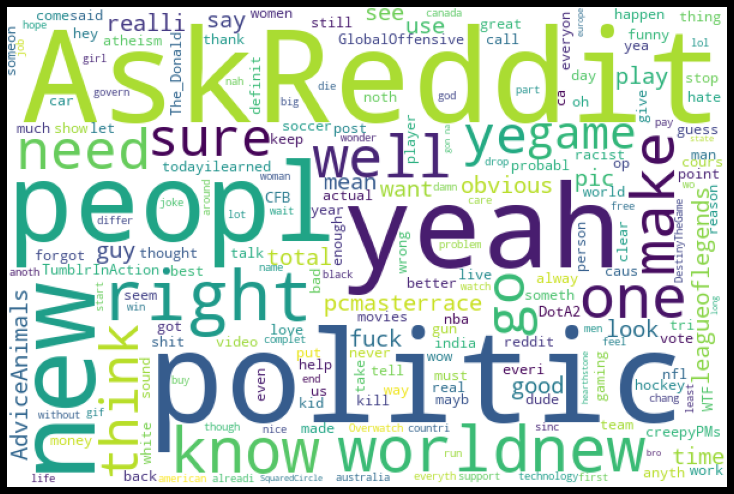

In [81]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [82]:
X2 = red_sample[['text']]
y2 = red_sample['label']

In [83]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [84]:
reddit_train2 = comment_vectorizer.fit_transform(X_train2['text'])
reddit_test2 = comment_vectorizer.transform(red_test2['text'])

#### Naive Bayes

In [85]:
naive_bayes2 = NB.fit(reddit_train2, y2_train)

In [86]:
naiveBayes_predict2 = NB.predict(reddit_test2)

In [87]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.64800158290463

Cross Validation:

In [88]:
NB_cv2 = cross_val_score(NB, reddit_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.63979226, 0.64395251, 0.65087806, 0.65013604, 0.64160277])

#### Random forest

In [89]:
random_forest.fit(reddit_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [90]:
randomForest_predict2 = random_forest.predict(reddit_test2)

In [91]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5555005935892362

Cross Validation:

In [92]:
rf_cv2 = cross_val_score(random_forest, reddit_train2, y2_train, n_jobs = -1)
rf_cv2

array([0.55063682, 0.56554539, 0.56393767, 0.55354934, 0.56245362])

#### Logistic regression

In [93]:
X3 = red_sample['text']
y3 = red_sample['label']

In [94]:
X_train3, red_test3, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20, random_state=28)

In [95]:
from sklearn.pipeline import Pipeline
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [96]:
tfidf_logit_pipeline.fit(X_train3, y3_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [97]:
roc_auc_score(y3_test, tfidf_logit_pipeline.predict_proba(red_test3)[:,1])

0.7131833264348624

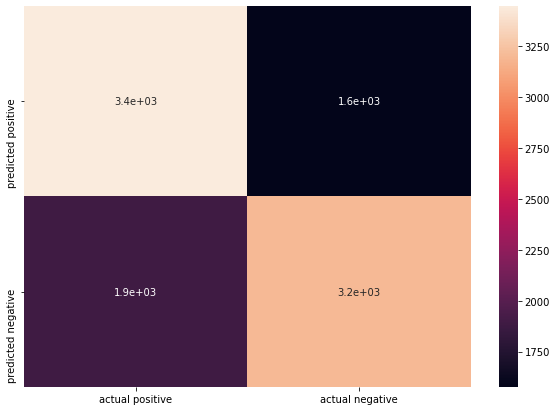

In [98]:
conf_mat3 = pd.DataFrame(confusion_matrix(y3_test, tfidf_logit_pipeline.predict(red_test3)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat3, annot=True)
plt.show()

GridSeachCV:

In [99]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [100]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [101]:
grid.fit(X_train3, y3_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    3.8s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [102]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2), use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train3, y3_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [103]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test3)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y3_test,predictions)),'\n')

Accuracy Score: 65.72% 



### Third Alternative

In [104]:
def addFeature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [105]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier as xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [106]:
X.head()

,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_parent,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,Placing a 5 minute queue ban on the player tha...,GlobalOffensive,4,0,NA Pro's dodging FPL matches by not readying u...,89,1,18,place minut queue ban player fail vote could s...,na pro dodg fpl match readi like team multipl ...,Highly Negative,"{faceit, match, ban, pro, abl, problem, addres...","{fail, ban, queue, minut, vote, could, solut, ...","{ban, queue}",2,0,20,-0.25,0.328571
1,"Venezuela where the prices are made up, and th...",nottheonion,-1,-1,Sounds like something Drew Carey would say.,72,3,12,venezuela price made currenc matter,sound like someth drew carey would say,Neutral,"{say, would, carey, sound, like, drew, someth}","{matter, venezuela, price, made, currenc}",{},0,0,3,0.00,0.000000
2,"With the way Deng's playing, I don't know any ...",lakers,-1,-1,I would say no; this team gets to the playoffs...,86,4,18,way deng play know team would bite trade,would say team get playoff lot luck even proba...,Positive,"{someon, playoff, luck, focus, may, even, get,...","{know, deng, would, trade, play, way, team, bite}","{deng, would, team, trade}",4,1,4,0.00,0.000000
3,inconceivable!,nfl,-1,-1,Yes! I've used that quote so many times over t...,14,1,1,inconceiv,yes use quot mani time year say unposs sound w...,Neutral,"{incorrect, say, weird, quot, time, yes, sound...",{inconceiv},{},0,0,2,0.00,0.000000
4,you saw the video too?,videos,264,0,The woman is Russian. ~~Not sure about the guy...,22,1,5,saw video,woman russian sure appar gibberish,Neutral,"{appar, sure, russian, gibberish, woman}","{video, saw}",{},0,0,4,0.00,0.000000


In [107]:
X_train3, red_test3, y_train_prov, y_test3 = train_test_split(X, y, test_size=0.20, random_state=28)

In [108]:
red_train3, red_val3, y_train3, y_val3 = train_test_split(X_train3, y_train_prov, test_size=0.2, random_state=28)

In [109]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
sentiment_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [110]:
clean_train3 = parent_vectorizer.fit_transform(red_train3['clean'])
clean_valid3 = parent_vectorizer.transform(red_val3['clean'])
clean_test3 = parent_vectorizer.transform(red_test3['clean'])

In [111]:
subred_train3 = subreddits_vectorizer.fit_transform(red_train3['subreddit'])
subred_valid3 = subreddits_vectorizer.transform(red_val3['subreddit'])
subred_test3 = subreddits_vectorizer.transform(red_test3['subreddit'])

In [112]:
sent_train = sentiment_vectorizer.fit_transform(red_train3['sentiment'])
sent_valid = sentiment_vectorizer.transform(red_val3['sentiment'])
sent_test = sentiment_vectorizer.transform(red_test3['sentiment'])

reddit_train3 = hstack([subred_train3, sent_train])
reddit_valid3 = hstack([subred_valid3, sent_valid])
reddit_test3 = hstack([subred_test3, sent_test])

In [113]:
reddit_train1_3 = hstack([clean_train3, subred_train3])
reddit_valid1_3 = hstack([clean_valid3, subred_valid3])
reddit_test1_3 = hstack([clean_test3, subred_test3])

In [114]:
reddit_train3 = hstack([reddit_train1_3, sent_train])
reddit_valid3 = hstack([reddit_valid1_3, sent_valid])
reddit_test3 = hstack([reddit_test1_3, sent_test])

In [115]:
reddit_train3 = addFeature(reddit_train3, red_train3['overlap_count'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['overlap_count'])
reddit_test3 = addFeature(reddit_test3, red_test3['overlap_count'])

In [116]:
reddit_train3 = addFeature(reddit_train3, red_train3['char'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['char'])
reddit_test3 = addFeature(reddit_test3, red_test3['char'])

In [117]:
reddit_train3 = addFeature(reddit_train3, red_train3['cap'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['cap'])
reddit_test3 = addFeature(reddit_test3, red_test3['cap'])

In [118]:
reddit_train3 = addFeature(reddit_train3, red_train3['punct'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['punct'])
reddit_test3 = addFeature(reddit_test3, red_test3['punct'])

In [119]:
reddit_train3 = addFeature(reddit_train3, red_train3['uppercase'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['uppercase'])
reddit_test3 = addFeature(reddit_test3, red_test3['uppercase'])

In [120]:
reddit_train3 = addFeature(reddit_train3, red_train3['ups'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['ups'])
reddit_test3 = addFeature(reddit_test3, red_test3['ups'])

In [121]:
reddit_train3 = addFeature(reddit_train3, red_train3['downs'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['downs'])
reddit_test3 = addFeature(reddit_test3, red_test3['downs'])

In [122]:
reddit_train3 = addFeature(reddit_train3, red_train3['polarity'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['polarity'])
reddit_test3 = addFeature(reddit_test3, red_test3['polarity'])

#### XGBoost

In [123]:
xgboost = XGBClassifier()
xgboost_model3 = xgboost.fit(reddit_train3, y_train3)
y_pred_xgboost3 = xgboost_model3.predict(reddit_test3)

In [124]:
accuracy_xgboost3 = accuracy_score(y_test3, y_pred_xgboost3)
print("Accuracy: %.2f%%" % (accuracy_xgboost3 * 100.0))

Accuracy: 62.46%


Confusion matrix:
 [[3779 1243]
 [2552 2534]]


C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


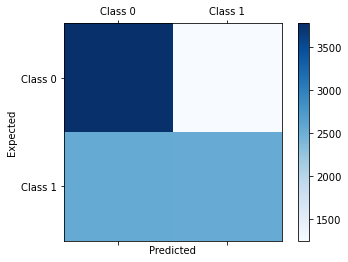

In [125]:
conf_mat_xbgoost3 = confusion_matrix(y_true = y_test3, y_pred = y_pred_xgboost3)
print('Confusion matrix:\n', conf_mat_xbgoost3)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_xbgoost3, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#### Logistic Regression

In [126]:
## Fit the model
logit_model3 = logit.fit(reddit_train3, y_train3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.8s finished


In [127]:
y_pred_logit3 = logit_model3.predict(reddit_test3)

Accurcay 0.5784527107241789
Precision 0.5753424657534246
Recall 0.619347227683838
F1 score 0.5965344190891014


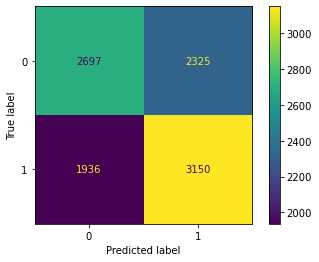

In [128]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test3, y_pred_logit3))
print("Precision", precision_score(y_test3, y_pred_logit3))
print("Recall",recall_score(y_test3, y_pred_logit3))
print("F1 score",f1_score(y_test3, y_pred_logit3))
plot_confusion_matrix(logit_model3, reddit_test3, y_test3)

#### KNN

In [129]:
knn_model3 = knn.fit(reddit_train3, y_train3)

In [130]:
y_knn_pred3 = knn_model3.predict(reddit_test3)
y_knn_pred3

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [131]:
print(knn_model3.score(reddit_test3, y_test3))

0.5523347843292442


#### Random Forest

In [132]:
random_forest_model3 = random_forest.fit(reddit_train3, y_train3)

In [133]:
randomForest_predict3 = random_forest_model3.predict(reddit_test3)

In [134]:
metrics.accuracy_score(y_test3, randomForest_predict3)

0.558369608231104

Cross Validation

In [135]:
rf_cv3 = cross_val_score(random_forest_model3, reddit_train3, y_train3, n_jobs = -1)
rf_cv3

array([0.55155356, 0.55820065, 0.55557273, 0.56840315, 0.55179344])